# Modal Explainability with Grad-CAM

##### Grad-CAM:

1. Computes gradients of the output w.r.t. CNN feature maps
2. Highlights important spatial regions
3. Produces a heatmap overlay on the image

🔴 Red = important

🔵 Blue = less important


#### 1. Loading CNN again ( Already in model_training file )

In [2]:
# imports
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Identity()
model = model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 2. Image Preprocessing

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


#### 3. Grad-CAM Implementation

In [5]:
# Target layer (last convolutional block)
target_layer = model.layer4

# Hook containers 
gradients = []
activations = []

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def forward_hook(module, input, output):
    activations.append(output)

# Register hooks
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


#### 4. Load one Image and Forward pass

In [7]:
img_path = "data/images/train/1000102.png"  
img = Image.open(img_path).convert("RGB")

input_tensor = transform(img).unsqueeze(0).to(device)

output = model(input_tensor)

e:\CDC project\cdc_clean\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


#### 5. Backward Pass

In [9]:
model.zero_grad()
output.backward(torch.ones_like(output))

#### 6. Compute Grad-CAM Heatmap

In [10]:
grads = gradients[0].cpu().data.numpy()
acts = activations[0].cpu().data.numpy()

weights = np.mean(grads, axis=(2, 3))[0]

cam = np.zeros(acts.shape[2:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * acts[0, i, :, :]

cam = np.maximum(cam, 0)
cam = cam / cam.max()

# Resize image
import cv2
cam = cv2.resize(cam, (224, 224))

#### 7. Overlay Heatmap on Images

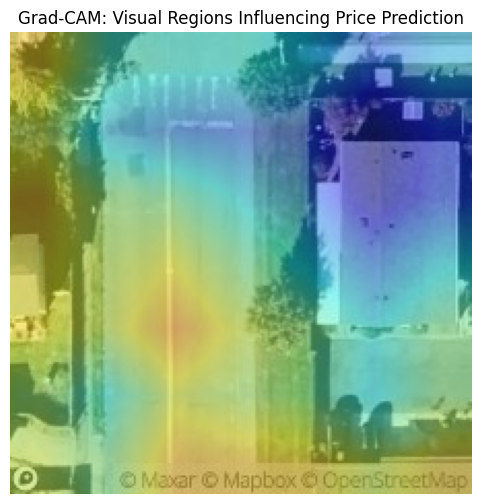

In [11]:
img_np = np.array(img.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM: Visual Regions Influencing Price Prediction")
plt.show()


🔴 High-price properties
Emphasis on:
1. greenery
2. wide roads
3. open spaces
4. low density

🔵 Low-price properties
Emphasis on:
1. dense clusters
2. irregular layouts
3. limited greenery
4. compact housing

Even if RMSE didn’t improve, this proves the CNN learned meaningful spatial cues.

#### 8. Grad-CAM over predefined Cheap and Expensive property

#### 8.(a) Loading Images

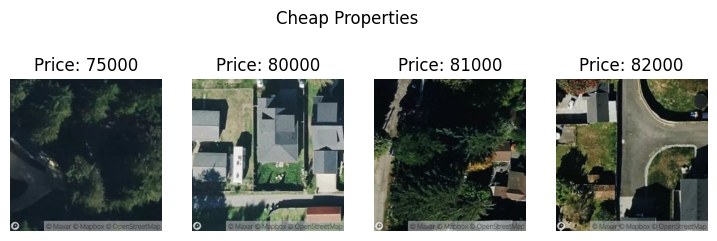

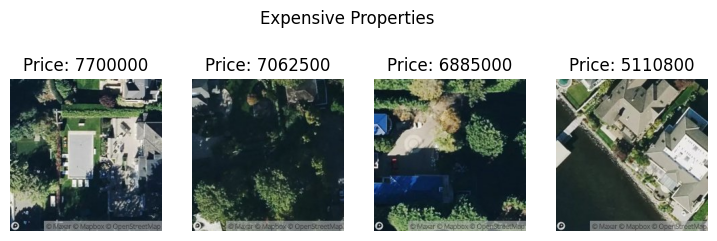

3656     3421079032
3789     8658300340
16074    3028200080
10552    3883800011
Name: id, dtype: int64
4962    6762700020
1499    9808700762
2115    9208900037
9264    1247600105
Name: id, dtype: int64


In [37]:
from PIL import Image
import pandas as pd 

train = pd.read_csv("data/train_processed.csv")

cheap = train.nsmallest(4, "price")
expensive = train.nlargest(4, "price")

def show_images(df, title):
    plt.figure(figsize=(9,3))
    for i, (_, row) in enumerate(df.iterrows()):
        img = Image.open(f"data/images/train/{row['id']}.png")
        plt.subplot(1,4,i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Price: {int(row['price'])}")
    plt.suptitle(title)
    plt.show()

show_images(cheap, "Cheap Properties")
show_images(expensive, "Expensive Properties")

print(cheap['id'])
print(expensive['id'])


#### 8.(b) Applying Grad-CAM

In [38]:
image_paths = {
    "c1": "data/images/train/3421079032.png",
    "c2": "data/images/train/8658300340.png",
    "c3": "data/images/train/3028200080.png",
    "c4": "data/images/train/3883800011.png",
    "e1": "data/images/train/6762700020.png",
    "e2": "data/images/train/9808700762.png",
    "e3": "data/images/train/9208900037.png",
    "e4": "data/images/train/9208900037.png",
}


import os
save_dir = "outputs/figures/grad_cam"
os.makedirs(save_dir, exist_ok=True)

for label, img_path in image_paths.items():
    
    # Load image
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Clear previous hooks data
    activations.clear()
    gradients.clear()

    # Forward pass
    output = model(input_tensor)

    # Backward pass (regression)
    model.zero_grad()
    output.backward(torch.ones_like(output))

    # Grad-CAM computation
    grads = gradients[0].cpu().detach().numpy()
    acts = activations[0].cpu().detach().numpy()

    weights = np.mean(grads, axis=(2, 3))[0]
    cam = np.zeros(acts.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts[0, i]

    cam = np.maximum(cam, 0)
    cam /= cam.max()
    cam = cv2.resize(cam, (224, 224))

    # Overlay heatmap
    img_np = np.array(img.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Save output
    save_path = os.path.join(save_dir, f"{label}_gradcam.png")
    cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    print(f"Saved Grad-CAM for {label}: {save_path}")

e:\CDC project\cdc_clean\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Saved Grad-CAM for c1: outputs/figures/grad_cam\c1_gradcam.png
Saved Grad-CAM for c2: outputs/figures/grad_cam\c2_gradcam.png
Saved Grad-CAM for c3: outputs/figures/grad_cam\c3_gradcam.png
Saved Grad-CAM for c4: outputs/figures/grad_cam\c4_gradcam.png
Saved Grad-CAM for e1: outputs/figures/grad_cam\e1_gradcam.png
Saved Grad-CAM for e2: outputs/figures/grad_cam\e2_gradcam.png
Saved Grad-CAM for e3: outputs/figures/grad_cam\e3_gradcam.png
Saved Grad-CAM for e4: outputs/figures/grad_cam\e4_gradcam.png


#### 8.(C) Display Heatmap

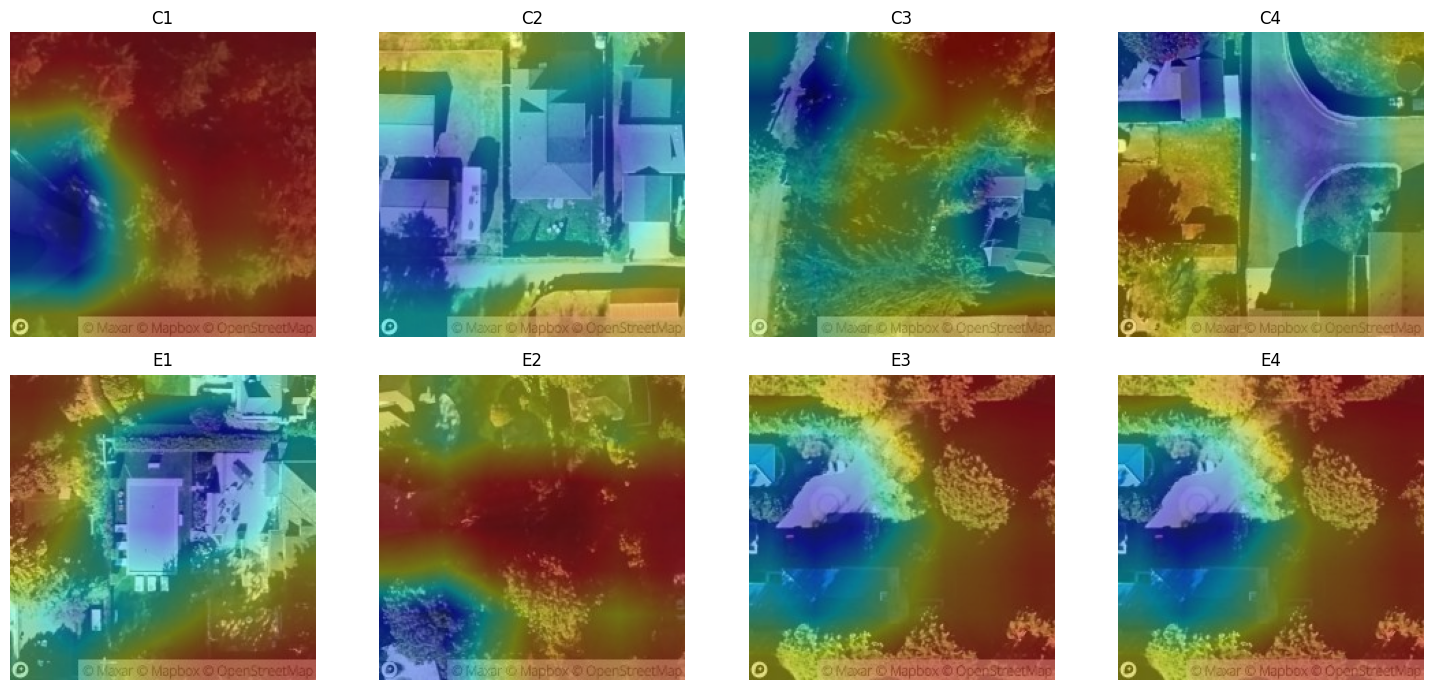

In [44]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,4 , figsize=(15,7))

for ax, label in zip(axes.flatten(), image_paths.keys()):
    img = Image.open(f"{save_dir}/{label}_gradcam.png")
    ax.imshow(img)
    ax.set_title(label.upper())
    ax.axis("off")

plt.tight_layout()
plt.show()


### Report

#### To interpret the contribution of satellite imagery, Grad-CAM was applied to the CNN feature extractor. Grad-CAM visualizations highlight spatial regions in the satellite images that most strongly influence the predicted property value. The results indicate that the model attends to neighborhood-level characteristics such as road structure, building density, and green cover. High-value properties tend to emphasize open spaces and greenery, while lower-value properties exhibit attention on dense and irregular urban layouts. These visual explanations validate that the CNN captures meaningful environmental context, even when the quantitative performance gains are limited.